# Brainlife analyses using Jupyter Notebooks and Python3

This example notebook will guide the user through grabbing data for their project from the secondary warehouse, compiling data across the entire project, and analyzing and visualizing the compiled results on brainlife.io via the 'Analysis' tab. This example is written for python3, and uses one of the Python3 notebook types.

Within this notebook, I will guide the user through analyses comprising derivatives generated from three main datatypes available on brainlife.io, specifically neuro/anat/t1w & t2w, neuro/dwi, and neuro/fmri. Specifically, I will guide the user through:
    
    1. Analyzing cortical parcel structural statistics, including cortical thickness, surface area, and volume from multiple parcellations (aparc.a2009s from Freesurfer and the HCP-MMP parcellation mapped using the Multi-Atlas Transfer Tool available on brainlife.io),
    
    2. Analyzing tract profilometry data and macrostructural statistics (length, streamline count, volume) using the 61 tract segmentation generated from the White Matter Anatomy Segmentation app available on brainlife.io
    
    3. Analyze structural and functional network matricies generated from dMRI and fMRI data using multiple atlases mapped, specifically the HCP-MMP and yeo-17 atlases respectively.
    
The functions provided in this notebook were designed for performing the many experiments provided in Hayashi & Caron et al (in prep), but should be a good starting point for you to get started on analyzing your project on brainlife.io!

##### Important Note regarding assumptions of data structures, both inputs and outputs

Before we get started, it is important to note at the begging that the code in this notebook was designed mostly with a stereotypical data structure format in mind. For many of the datatypes, specifically the csv datatypes, follow the tidy format [https://www.jstatsoft.org/article/view/v059i10], where "each column is a variable, every row is an observation, and every cell is a singular value"[https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html]. There will be a few common columns, specifically 'subjectID' denoting the brainlife subject ID, 'sessionID' denoting the session ID on brainlife (will be 1 if there is no session ID data available), 'structureID' denoting the tissue structure of interest (ex. white matter tract, cortical parcel, eeg node), and 'nodeID' denoting the sample number of the structure. 'nodeID' is included across many .csv-based datatypes to conform with profilometry data, which has multiple samples or nodes per structure. For single measures of a given structure, the nodeID for all structures will be 1. 

However, this is not the case for network adjacency matrices. Specifically with the network.json.gz files that come within the generic/network datatype, the resulting compiled data structure will be compiled as a json structure with a numpy array of the matrix for each subject and session. 

I will provide examples of these resulting structures later on in the notebook.

I bring this up now to note that if you are not a fan of the style of the resulting data structures, or your data doesn't confirm to this style, you are free to alter this code to your deepest desires! I've attempted to do my best to comment and explain everything as much as possible for each section, function, and analysis. If there are any points where something is not working or you are not sure what the code is doing, feel free to email me at [bacaron245@gmail.com!]

# With that, let's get started!

The first things we need to do are to install some software packages using python's pip package manager, and then to load all of the necessary modules into our notebook.

Specifically, we will install the python-import of the brain connectivity toolbox (BCT; ) known as bctpy [], jgf to load json packages (for our network matrices), and nilearn to make some pretty network plots!

We will also be loading some other packages, including matplotlib, seaborn, and nilearn for plotting, numpy for numerical calculations and array manipulations, itertools and scipy for statistical testing, pandas, json, and jgf for loading various datat strucutres, and scikit-learn's mean_squared_error function to compute root-mean-square-error for some of the final analyses. 

In [1]:
pip install bctpy jgf nilearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os,sys,glob
import requests
from matplotlib import colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns
from itertools import combinations
from sklearn.metrics import mean_squared_error
from scipy import stats
import bct
import jgf
from nilearn import plotting

# Let's define and load some useful functions!

This next section loads many functions for loading, compiling, analyzing, and visualizing some common datatypes on brainlife.io. To make it easier to load, I've provided all the functions used throughout the rest of the notebook in a single cell. However, for each function, I've provided comments that attempt to explain what the function does and what the inputs and outputs are. I've sectioned off the code into multiple sections: 1) data loading, compilation, and storage, 2) data analysis, manipulation and statistical computations, and 3) visualizations.

## Data loading, compilation, and storage
The first section of functions deals with collecting data from secondary warehouse and compiling the data into a useful structures for further analysis. The main function the user will call from this section is the wrapper 'collectData', which will identify the appropriate data from the secondary warehouse based on user input and compile that data into a structure the user can use for analysis. This function makes a couple of important assumptions. Specifically:

    1. If there are duplicate datatypes that meet all of the specifications and filters, this function will only collect the data that was most recent to finish
    
    2. If the data can be formatted to a csv-file, it will be formatted to a csv-file. The only exception is network adjacency matrices.
    
    3. Users can control what data is grabbed and compiled by being specific with datatype_tags and tags.
    
The remaining functions perform other useful tasks, such as adding subjectID and sessionID data if missing, checking for duplicate entries of the same datatype (assumption 1), and append and compile data into the output data structure.

As previously mentioned, the resulting csv-file structures will be in the tidy format, and network adjacency matricies will be stored as a json-structure with the matricies stored as numpy arrays.

In [3]:
## this will add a subjectID and sessionID column to the output data
def addSubjectsSessions(subject,session,path,data):
    
    if 'subjectID' not in data.keys():
        data['subjectID'] = [ str(subject) for f in range(len(data)) ]
    
    if 'sessionID' not in data.keys():
        data['sessionID'] = [ str(session) for f in range(len(data)) ]
        
    return data

## this function is useful for identifying duplicate datatypes. if it finds one, it will update the data with the latest finishing dataset.
def checkForDuplicates(obj,finish_dates,subjects,sessions,paths):
    
    # first checks if there is a session id available in the keys of the object. if finds one, then checks if the subject and session ID 
    # were already looped over. if so, will delete position in list and update with appropriate path. if it doesn't find a session ID, it
    # just attempts to find if the subject has already been looped over
    if 'session' in obj['output']['meta'].keys():
        if (obj['output']['meta']['subject'] in subjects) and (obj['output']['meta']['session'] in sessions):
            index = np.where(np.logical_and(subjects == obj['output']['meta']['subject'],sessions == obj['output']['meta']['session']))
            if finish_dates[index] <= obj["finish_date"]:
                subjects = np.delete(subjects,index)
                paths = np.delete(paths,index)
                sessions = np.delete(sessions,index)
                finish_dates = np.delete(finish_dates,index)
    else:
        if (obj['output']['meta']['subject'] in subjects):
            index = np.where(subjects == obj['output']['meta']['subject'])
            if finish_dates[index] <= obj["finish_date"]:
                subjects = np.delete(subjects,index)
                paths = np.delete(paths,index)
                sessions = np.delete(sessions,index)
                finish_dates = np.delete(finish_dates,index)

    return finish_dates, subjects, sessions, paths

## this function calles checkForDuplicates and attempts to find duplicates. then uses that output, sets a dumby sessionID if not present,
## and appends the object data
def appendData(subjects,sessions,paths,finish_dates,obj,filename):
        
    # check for duplicates. if so, remove
    finish_dates, subjects, sessions, paths = checkForDuplicates(obj,finish_dates,subjects,sessions,paths)

    # append data to appropriate lists
    subjects = np.append(subjects,obj['output']['meta']['subject'])
    if 'session' in obj['output']['meta'].keys():
        sessions = np.append(sessions,obj['output']['meta']['session'])
    else:
        sessions = np.append(sessions,'1')
    paths = np.append(paths,"input/"+obj["path"]+"/"+filename)
    finish_dates = np.append(finish_dates,obj['finish_date'])
    
    return finish_dates, subjects, sessions, paths

## this function will call addSubjectsSessions to add the appropriate columns and will append the object data to a study-wide dataframe
def compileData(paths,subjects,sessions,data):
    # loops through all paths
    for i in range(len(paths)):
        # if network, load json. if not, load csv
        if '.json.gz' in paths[i]:
            tmpdata = pd.read_json(paths[i],orient='index').reset_index(drop=True)
            tmpdata = addSubjectsSessions(subjects[i],sessions[i],paths[i],tmpdata)
        else:
            tmpdata = pd.read_csv(paths[i])
            tmpdata = addSubjectsSessions(subjects[i],sessions[i],paths[i],tmpdata)

        data = data.append(tmpdata,ignore_index=True)

    # replace empty spaces with nans
    data = data.replace(r'^\s+$', np.nan, regex=True)
    
    return data

def compileNetworkAdjacencyMatrices(paths,subjects,sessions,data):
    
    # loop through paths and append adjacency matrix to dictionary
    for i in range(len(paths)):
        data[subjects[i]+'_sess'+sessions[i]] = jgf.conmat.load(paths[i],compressed=True)[0]

    return data

## this function is the wrapper function that calls all the prevouis functions to generate a dataframe for the entire project of the appropriate datatype
def collectData(datatype,datatype_tags,tags,filename,outPath,net_adj):

    # grab path and data objects
    objects = requests.get('https://brainlife.io/api/warehouse/secondary/list/%s'%os.environ['PROJECT_ID']).json()
    
    # subjects and paths
    subjects = []
    sessions = []
    paths = []
    finish_dates = []
    
    # set up output
    data = pd.DataFrame()

    # loop through objects and find appropriate objects based on datatype, datatype_tags, and tags. can include drop tags ('!'). this logic could probably be simplified
    for obj in objects:
        if obj['datatype']['name'] == datatype:
            # if datatype_tags is set, identify data using this info. if not, just use tag data. if no tags either, just append if meets datatype criteria. will check for filter with a not tag (!)
            if datatype_tags:
                # if the input datatype_tags are included in the object's datatype_tags, look for appropriate tags. if no tags, just append
                if set(datatype_tags).issubset(obj['output']['datatype_tags']):
                    # if tags is set, identify the data using this info
                    if tags:
                        # if input tags are included in object's tags, append. check if user wants to filter with a not tag (!)
                        if set(tags).issubset(obj['output']['tags']):
                            finish_dates, subjects, sessions, paths = appendData(subjects,sessions,paths,finish_dates,obj,filename)
                        elif '!' in str(tags):
                            tag = [ f for f in tags if '!' in str(f) ]
                            tag_drop = [ f for f in tags if f not in tag ]
                            if not set([ f.replace('!','') for f in tag]).issubset(obj['output']['tags']):
                                if set(tag_drop).issubset(obj['output']['tags']):
                                    finish_dates, subjects, sessions, paths = appendData(subjects,sessions,paths,finish_dates,obj,filename)
                    else:
                        finish_dates, subjects, sessions, paths = appendData(subjects,sessions,paths,finish_dates,obj,filename)
                elif '!' in str(datatype_tags): # if a not filter was detected in the tag, clean tags to remove !, skip any objects that have those tags, append those that do not have those tags
                    datatype_tag = [ f for f in datatype_tags if '!' in str(f) ]
                    datatype_tag_drop = [ f for f in datatype_tags if f not in datatype_tag ]
                    if not set([ f.replace('!','') for f in datatype_tag]).issubset(obj['output']['datatype_tags']):
                        if tags:
                            # if input tags are included in object's tags, append. check if user wants to filter with a not tag (!)
                            if set(tags).issubset(obj['output']['tags']):
                                finish_dates, subjects, sessions, paths = appendData(subjects,sessions,paths,finish_dates,obj,filename)
                            elif '!' in str(tags):
                                tag = [ f for f in tags if '!' in str(f) ]
                                tag_drop = [ f for f in tags if f not in tag ]
                                if not set([ f.replace('!','') for f in tag]).issubset(obj['output']['tags']):
                                    if set(tag_drop).issubset(obj['output']['tags']):
                                        finish_dates, subjects, sessions, paths = appendData(subjects,sessions,paths,finish_dates,obj,filename)
                        else:
                            finish_dates, subjects, sessions, paths = appendData(subjects,sessions,paths,finish_dates,obj,filename)
            else:
                if tags:
                # if input tags are included in object's tags, append. check if user wants to filter with a not tag (!)
                    if set(tags).issubset(obj['output']['tags']):
                        finish_dates, subjects, sessions, paths = appendData(subjects,sessions,paths,finish_dates,obj,filename)
                    elif '!' in str(tags):
                        tag = [ f for f in tags if '!' in str(f) ]
                        tag_drop = [ f for f in tags if f not in tag ]
                        if not set([ f.replace('!','') for f in tag]).issubset(obj['output']['tags']):
                            if set(tag_drop).issubset(obj['output']['tags']):
                                finish_dates, subjects, sessions, paths = appendData(subjects,sessions,paths,finish_dates,obj,filename)
                else:
                    finish_dates, subjects, sessions, paths = appendData(subjects,sessions,paths,finish_dates,obj,filename)

    # shuffle data so subjects are in order
    paths = [z for _,_,z in sorted(zip(subjects,sessions,paths))]
    subjects = [x for x,_,_ in sorted(zip(subjects,sessions,paths))]
    sessions = [y for _,y,_ in sorted(zip(subjects,sessions,paths))]
    
    # compile data
    if net_adj:
        data = {}
        data = compileNetworkAdjacencyMatrices(paths,subjects,sessions,data)
        np.save(outPath,data)
    else:
        data = compileData(paths,subjects,sessions,data)
    
        # output data structure for records and any further analyses
        # subjects.csv
        data.to_csv(outPath,index=False)
    
    return data

### subjects dataframe generation
## this function will make a dataframe from a list of subjects and groups. will also add a color column for easy plotting
def collectSubjectData(topPath,dataPath,groups,subjects,colors):

    # set up variables
    data_columns = ['subjectID','classID','colors']
    data =  pd.DataFrame([],columns=data_columns)

    # populate structure
    data['subjectID'] = [ f for g in groups for f in subjects[g] ]
    data['classID'] = [ g for g in groups for f in range(len(subjects[g]))]
    data['colors'] = [ colors[c] for c in colors for f in subjects[c]]

    # output data structure for records and any further analyses
    if not os.path.exists(dataPath):
        os.mkdir(dataPath)

    data.to_csv(dataPath+'subjects.csv',index=False)

    return data

## this will create a subject-specific color for each subject in the subjects dataframe
def createColorDictionary(data,measure,colorPalette):

    # Create subject keys and color values
    keys = data[measure].unique()
    values = sns.color_palette(colorPalette,len(keys))
    values = values.as_hex()

    # zip dictionary together
    colors_dict = dict(zip(keys,values))

    return colors_dict

# Data analysis, manipulation and statistical computations
This next section contains functions for manipulating, analysing, and computing statistics from the data collected using the functions previously described. This includes many different manipulations and computations, including trimming nodes off profilometry data, computing mean dataframes, computing outliers and generating reference datasets, and some simple network adjacency matrix manipulations including binarizing, thresholding, and computing the mean witihin-network functional connectivity. 

The bulk of these functions are devoted to identifying outliers and generating reference datasets. My approach for this included identifying outliers for each structure and measure across a given project  by computing the mean distribution and identifying those with distances from that point greater than a percentile threshold. I then removed those data points, and recomputed the reference dataset. The references generated have been built-into many of the verification steps following Apps. The resulting dataframes are formatted in both csv and json structures.

In [4]:
### dataframe manipulations
## cut nodes for profilometry / timeseries data
def cutNodes(data,num_nodes,dataPath,foldername,savename):

    # identify inner n nodes based on num_nodes input
    total_nodes = len(data['nodeID'].unique())
    cut_nodes = int((total_nodes - num_nodes) / 2)

    # remove cut_nodes from dataframe
    data = data[data['nodeID'].between((cut_nodes)+1,(num_nodes+cut_nodes))]

    # replace empty spaces with nans
    data = data.replace(r'^\s+$', np.nan, regex=True)

    # output data structure for records and any further analyses
    if not os.path.exists(dataPath):
        os.mkdir(dataPath)

    data.to_csv(dataPath+'/'+foldername+'-'+savename+'.csv',index=False)

    return data

## will compute mean dataframe 
def computeMeanData(dataPath,data,outname):

    # make mean data frame
    data_mean =  data.groupby(['subjectID','classID','structureID']).mean().reset_index()
    data_mean['nodeID'] = [ 1 for f in range(len(data_mean['nodeID'])) ]

    # output data structure for records and any further analyses
    if not os.path.exists(dataPath):
        os.mkdir(dataPath)

    data_mean.to_csv(dataPath+outname+'.csv',index=False)

    return data_mean

### scripts related to outlier detection and reference dataframe generation
## this function will compute distance measures from input data and reference data
def computeDistance(data,references_data,measures,metric):

    # imports important distance functions
    from sklearn.metrics.pairwise import euclidean_distances
    from scipy.stats import wasserstein_distance

    # if distance metric desired is euclidean distance (i.e. for profiles), computes distance of profile from reference profile. else, just computes difference using emd
    if metric == 'euclidean':
        dist = data.groupby('subjectID',sort=False).apply(lambda x: euclidean_distances([x[measures].values.tolist(),references_data[measures].values.tolist()])[0][1]).values
    else:
        dist = data.groupby('subjectID',sort=False).apply(lambda x: wasserstein_distance(x[measures],[references_data[measures].values[0]]))

    return dist

## this function will compute simple average references for a given input data
def computeReferences(x,groupby_measures,index_measure,diff_measures):
    
    # computes mean and sd of the measures in a dataframe
    references_mean = x.groupby(groupby_measures).mean().reset_index(index_measure)
    references_sd = x.groupby(groupby_measures).std().reset_index(index_measure)
    references_sd[diff_measures] = references_sd[diff_measures] * 2
    
    return references_mean, references_sd

## this function calls computeReferences and computeDistances to create a dataframe of distance measures
def createDistanceDataframe(data,structures,groupby_measure,measures,dist_metric):
    
    # set up output lists that we will append to
    dist = []
    subj = []
    meas = []
    struc = []

    # loop through appropriate structures
    for i in structures:
        print(i)
        # set data for a given structure
        subj_data = data.loc[data['structureID'] == i]
        # compute reference for given structure
        references_data = computeReferences(subj_data,groupby_measure,groupby_measure,measures)
        # loop through measures and compute distance from reference
        for m in measures:
            if dist_metric == 'euclidean':
                dist = np.append(dist,computeDistance(subj_data,references_data[0],m,'euclidean'))
            else:
                dist = np.append(dist,computeDistance(subj_data,references_data[0],m,'emd'))
            
            # append data to appropriate lists
            subj = np.append(subj,subj_data.subjectID.unique().tolist())
            meas = np.append(meas,[ m for f in range(len(subj_data.subjectID.unique().tolist())) ])
            struc = np.append(struc,[ i for f in range(len(subj_data.subjectID.unique().tolist())) ])

    # create distance dataframe
    dist_dataframe = pd.DataFrame()
    dist_dataframe['subjectID'] = subj
    dist_dataframe['structureID'] = struc
    dist_dataframe['measures'] = meas
    dist_dataframe['distance'] = dist
    
    return dist_dataframe

## this function is useful for saving reference.jsons for a given structure
def outputReferenceJson(ref_data,measures,profile,resample_points,sourceID,data_dir,filename):
    
    # load module for resampling profile data for generating reference.json
    from scipy.signal import resample

    # loop through structures in dataframe
    for st in ref_data.structureID.unique():
        # set up important measures
        reference_json = []
        tmp = {}
        tmp['structurename'] = st
        tmp['source'] = sourceID
        # loop through measures
        for meas in measures:
            # grab data
            tmp[meas] = {}
            if profile:
                gb_frame = ref_data.loc[ref_data['structureID'] == st][['nodeID',meas]].dropna().groupby('nodeID')[meas]
            else:
                gb_frame = ref_data.loc[ref_data['structureID'] == st][[meas]].dropna()[meas]
            
            # if resample_points is a value, resamples references and computes multiple summary measures.
            # else, will just output the entire data. this second option is really only useful for non-profile/series data
            data_tmp = []
            if resample_points:                
                mean_tmp = resample(gb_frame.mean().values.tolist(),resample_points).tolist()
                min_tmp = resample(gb_frame.min().values.tolist(),resample_points).tolist()
                max_tmp = resample(gb_frame.max().values.tolist(),resample_points).tolist()
                sd_tmp = resample(gb_frame.std().values.tolist(),resample_points).tolist()
                five_tmp = resample(gb_frame.quantile(q=.05).values.tolist(),resample_points).tolist()
                twofive_tmp = resample(gb_frame.quantile(q=.25).values.tolist(),resample_points).tolist()
                sevenfive_tmp = resample(gb_frame.quantile(q=.75).values.tolist(),resample_points).tolist()
                ninefive_tmp = resample(gb_frame.quantile(q=.95).values.tolist(),resample_points).tolist()
                tmp[meas]['mean'] = mean_tmp
                tmp[meas]['min'] = min_tmp
                tmp[meas]['max'] = max_tmp
                tmp[meas]['sd'] = sd_tmp
                tmp[meas]['5_percentile'] = five_tmp
                tmp[meas]['25_percentile'] = twofive_tmp
                tmp[meas]['75_percentile'] = sevenfive_tmp
                tmp[meas]['95_percentile'] = ninefive_tmp
            else:
                data_tmp = gb_frame.values.tolist()
                tmp[meas]['data'] = data_tmp
        reference_json.append(tmp)

        with open(data_dir+'/'+filename+'_'+st+'.json','w') as ref_out_f:
            json.dump(reference_json,ref_out_f)
    
    return reference_json

## this function is used to build the reference dataset removing any subjects identified as outliers. the dataframe may or may not be useful
def buildReferenceData(data,outliers,profile,data_dir,filename):
    
    # set up dataframe
    reference_data = pd.DataFrame()

    # loop through structures and measures and set data
    for s in outliers.structureID.unique():
        for m in outliers.measures.unique():
            if profile:
                meas = ['structureID','subjectID','nodeID',m]
            else:
                meas = ['structureID','subjectID',m]
            tmpdata = data[(data["structureID"] == s) & (~data['subjectID'].isin(outliers.loc[outliers['structureID'] == s].loc[outliers['measures'] == m].subjectID.unique()))][meas].reset_index(drop=True)
            reference_data = pd.concat([reference_data,tmpdata])
    # if not profile, will compute average
    if not profile:
        reference_data = reference_data.groupby(['structureID','subjectID']).mean().reset_index()

    reference_data.to_csv(data_dir+'/'+filename+'.csv',index=False)

    return reference_data

## this function will identify if a given subjects' data is an outlier based on distance from reference and a threshold percentage
def computeOutliers(distances,threshold):
    
    # set up dataframe
    outliers = pd.DataFrame()
    
    # loop through structureas and measures and identify outliers based on thereshold distance
    for i in distances.structureID.unique():
        for m in distances.measures.unique():
            tmpdata = distances.loc[distances['structureID'] == i].loc[distances['measures'] == m]
            outliers = pd.concat([outliers,tmpdata[tmpdata['distance'] > np.percentile(tmpdata['distance'],threshold)]])
            
    return outliers

## this function calls computeOutliers, createDistanceDataframe, and buildReferenceData and outputReferenceJson to actually generate the outliers
## and final reference datasets
def outlierDetection(data,structures,groupby_measure,measures,threshold,dist_metric,build_outliers,profile,resample_points,sourceID,data_dir,filename):
    
    # set up important lists
    outliers_subjects = []
    outliers_structures = []
    outliers_measures = []
    outliers_metrics = []

    # compute distances and identify outliers
    distances = createDistanceDataframe(data,structures,groupby_measure,measures,dist_metric)
    outliers_dataframe = computeOutliers(distances,threshold)
    
    # if building references, build the reference data. otherwise, output a blank array
    if build_outliers:
        reference_dataframe = buildReferenceData(data,outliers_dataframe,profile,data_dir,filename)
        reference_json = outputReferenceJson(reference_dataframe,measures,profile,resample_points,sourceID,data_dir,filename)
    else:
        reference_dataframe = []
        reference_json = []
        
    return distances, outliers_dataframe, reference_dataframe, reference_json

## this function is useful in identifying subjects who may have had a flipped profile as compared to a reference profile.
## calls computeReferences, computeDistance.
## logic: if the distance of a subject's tract profile from a reference profile is positive and greater than a threshold percentage, then it's likely
## the data has been flipped. needs more work for all use cases. works well for easy examples like uncinate
def profileFlipCheck(data,subjects,structures,test_measure,flip_measures,dist_metric,threshold,outPath):
    
    # set up important lists
    flipped_subjects = []
    flipped_structures = []
    distance = []
    flipped_distance = []

    # loop through structures
    for i in structures:
        print(i)
        # set data frame for structure, including a copy that has the test_measure flipped
        struc_data = data.loc[data['structureID'] == i]
        flipped_struc_data = struc_data.copy()
        flipped_struc_data[test_measure] = flipped_struc_data.groupby('subjectID',sort=False).apply(lambda x: np.flip(x['fa'])).tolist()

        # build reference data
        references_data = computeReferences(struc_data,'nodeID','nodeID',flip_measures)

        # compute distances for normal data and for flipped. then compute difference
        dist = computeDistance(struc_data,references_data[0],test_measure,dist_metric)
        dist_flipped = computeDistance(flipped_struc_data,references_data[0],test_measure,dist_metric)
        differences = dist - dist_flipped

        # identify threshold of distances based on percentile. identify those that have positive differences and are greater than the threshold.
        # if so, append information
        percentile_threshold = np.percentile(differences,threshold)
        for m in range(len(differences)):
            if differences[m] > 0 and differences[m] > percentile_threshold:
                flipped_subjects = np.append(flipped_subjects,subjects[m])
                flipped_structures = np.append(flipped_structures,i)
                distance = np.append(distance,dist[m])
                flipped_distance = np.append(flipped_distance,dist_flipped[m])

    # generate ouput dataframe containing flipped subject data
    output_summary = pd.DataFrame()
    output_summary['flipped_subjects'] = flipped_subjects
    output_summary['flipped_structures'] = flipped_structures
    output_summary['distance'] = distance
    output_summary['flipped_distance'] = flipped_distance

    if outPath:
        output_summary.to_csv(outPath+'_flipped_profiles.csv',index=False)
        
# this function will merge the structural and diffusion data for the reference datasets
def mergeStructuralDiffusionJson(data,structuralPath,diffusionPath,outPath):
    for i in data.structureID.unique():
        print(i)
        with open(structuralPath+'_'+i+'.json','r') as structural_f:
            structural = json.load(structural_f)

        with open(diffusionPath+'_'+i+'.json','r') as diffusion_f:
            diffusion = json.load(diffusion_f)

        merged = {**structural[0],**diffusion[0]}

        with open(outPath+'_'+i+'.json','w') as out_f:
            json.dump(merged,out_f)

### adjacency-matrix related fuctions for computing network values locally
def binarizeMatrices(data):
    
    # use brain connectivity toolbox to binarize data
    bin_data = [ bct.utils.binarize(data[f]) for f in data.keys() ]
    
    return bin_data

def thresholdMatrices(data,bin_data,thresholdPercentageSubjects):
    
    # compute sum of matrices
    sum_mat = np.zeros(np.shape(bin_data)[1:])
    
    for i in bin_data:
        sum_mat = sum_mat + i
        
    # compute threshold value
    thrs = thresholdPercentageSubjects*len(bin_data)
    
    # loop through data and make those nodes that dont meet threshold 0
    for i in data.keys():
        data[i][sum_mat < thrs] = 0
        
    return data

def computeMeanNetworkConnectivity(data,networks,indices,out_path):

    mean_data = []
    subs = []
    nets = []

    for l in data.keys():
        for n in networks:
            tmpdata = []
            subs = np.append(subs,l)
            nets = np.append(nets,n)
            for i in indices[n]:
                for j in indices[n]:
                    if i != j:
                        tmpdata = np.append(tmpdata,data[l][int(i)][int(j)])
            mean_data = np.append(mean_data,np.mean(tmpdata))

    out_df = pd.DataFrame()
    out_df['subjectID'] = [ f.split('_sess1')[0] for f in subs ]
    out_df['FC'] = mean_data
    out_df = pd.merge(out_df,subjects_data,on='subjectID')
    out_df['structureID'] = nets

    if out_path:
        out_df.to_csv(out_path,index=False)
        
    return out_df



# Visualizations
The final set of functions deals with generating many useful visualizations and plots of the data, including scatterplots, violin plots, and tract profile plots. Within this are many useful wrapper functions that organize the data into useful structures for plotting. These scripts are very 'baked in', in that they are in a style that I like. However, many of these visualizations can be changed with simple alterations to the code. Many of the plots use packages like seaborn or matplotlib to make the visualizations, which both have extensive documentation to guide and help!

In [5]:
### scatter plot related scripts
def plotProfiles(structures,stat,diffusion_measures,summary_method,error_method,dir_out,img_name):

    import matplotlib.pyplot as plt
    import os,sys
    import seaborn as sns
    from scipy import stats
    import numpy as np

    # loop through all structures
    for t in structures:
        print(t)
        # loop through all measures
        for dm in diffusion_measures:
            print(dm)

            imgname=img_name+"_"+t+"_"+dm

            # generate figures
            fig = plt.figure(figsize=(15,15))
            fig.patch.set_visible(False)
            p = plt.subplot()

            # set title and catch array for legend handle
            plt.title("%s Profiles %s: %s" %(summary_method,t,dm),fontsize=20)

            # loop through groups and plot profile data
            for g in range(len(stat.classID.unique())):
                # x is nodes
                x = stat['nodeID'].unique()

                # y is summary (mean, median, max, main) profile data
                if summary_method == 'mean':
                    y = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).mean()[dm][t]
                elif summary_method == 'median':
                    y = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).median()[dm][t]
                elif summary_method == 'max':
                    y = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).max()[dm][t]
                elif summary_method == 'min':
                    y = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).min()[dm][t]

                # error bar is either: standard error of mean (sem), standard deviation (std)
                if error_method == 'sem':
                    err = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).std()[dm][t] / np.sqrt(len(stat[stat['classID'] == stat.classID.unique()[g]]['subjectID'].unique()))
                else:
                    err = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).std()[dm][t]

                # plot summary
                plt.plot(x,y,color=stat[stat['classID'] == stat.classID.unique()[g]]['colors'].unique()[0],linewidth=5,label=stat.classID.unique()[g])

                # plot shaded error
                plt.fill_between(x,y-err,y+err,alpha=0.2,color=stat[stat['classID'] == stat.classID.unique()[g]]['colors'].unique()[0],label='1 %s %s' %(error_method,stat.classID.unique()[g]))

            # set up labels and ticks
            plt.xlabel('Location',fontsize=18)
            plt.ylabel(dm,fontsize=18)
            plt.xticks([x[0],x[-1]],['Begin','End'],fontsize=16)
            plt.legend(fontsize=16)
            y_lim = plt.ylim()
            plt.yticks([np.round(y_lim[0],2),np.mean(y_lim),np.round(y_lim[1],2)],fontsize=16)

            # remove top and right spines from plot
            p.axes.spines["top"].set_visible(False)
            p.axes.spines["right"].set_visible(False)

            # save image or show image
            saveOrShowImg(dir_out,dm,dm,imgname)


# groups data by input measure and computes mean for each value in that column. x_stat is a pd dataframe, with each row being a single value, and each column being a different ID value or measure
def averageWithinColumn(x_stat,y_stat,x_measure,y_measure,measure):

    X = x_stat.groupby(measure).mean()[x_measure].tolist()
    Y = y_stat.groupby(measure).mean()[y_measure].tolist()

    return X,Y

# groups data by input measure and creates an array by appending data into x and y arrays. x_stat and y_stat are pd dataframes, with each row being a single value, and each column being a different ID value or measure
# designed for test retest. x_stat and y_stat should have the same number of rows. but more importantly, should correspond to the same source (i.e. subject)
# can be same pd.dataframe, but indexing of specific subject groups
def appendWithinColumn(x_stat,y_stat,x_measure,y_measure,measure):

    X,Y = [np.array([]),np.array([])]
    for i in range(len(x_stat[measure].unique())):
        x = x_stat[x_stat[measure] == x_stat[measure].unique()[i]][x_measure]
        y = y_stat[y_stat[measure] == y_stat[measure].unique()[i]][y_measure]

        if np.isnan(x).any() or np.isnan(y).any():
            print("skipping %s due to nan" %x_stat[measure].unique()[i])
        else:
            # checks to make sure the same data
            if len(x) == len(y):
                X = np.append(X,x)
                Y = np.append(Y,y)

    return X,Y

# unravels networks. x_stat and y_stat should be S x M, where S is the number of subjects and M is the adjacency matrix for that subject
def ravelNetwork(x_stat,y_stat):

    import numpy as np

    X = np.ravel(x_stat).tolist()
    Y = np.ravel(y_stat).tolist()

    return X,Y

# unravels nonnetwork data. x_stat and y_stat should be pd dataframes. x_measure and y_measure are the measure to unrvavel. 
# designed for test retest. x_stat and y_stat should have the same number of rows. but more importantly, should correspond to the same source (i.e. subject)
# can be same pd.dataframe, but indexing of specific subject groups
def ravelNonNetwork(x_stat,y_stat,x_measure,y_measure):

    X = x_stat[x_measure].to_list()
    Y = y_stat[y_measure].to_list()

    return X,Y

# wrapper function to call either of the above scripts based on user input
def setupData(x_data,y_data,x_measure,y_measure,ravelAverageAppend,isnetwork,measure):

    x_stat = x_data
    y_stat = y_data

    if ravelAverageAppend == 'average':
        X,Y = averageWithinColumn(x_stat,y_stat,x_measure,y_measure,measure)
    elif ravelAverageAppend == 'append':
        X,Y = appendWithinColumn(x_stat,y_stat,x_measure,y_measure,measure)
    elif ravelAverageAppend == 'ravel':
        if isnetwork == True:
            X,Y = ravelNetwork(x_stat,y_stat)
        else:
            X,Y = ravelNonNetwork(x_stat,y_stat,x_measure,y_measure)

    return x_stat,y_stat,X,Y

# function to shuffle data and colors
def shuffleDataAlg(X,Y,hues):

    from sklearn.utils import shuffle

    X,Y,hues = shuffle(X,Y,hues)

    return X,Y,hues

# simple display or figure save function
def saveOrShowImg(dir_out,x_measure,y_measure,img_name):
    import os,sys 
    import matplotlib.pyplot as plt
    import warnings
    
    with warnings.catch_warnings():
        # this will suppress all warnings in this block
        warnings.simplefilter("ignore")
 
        # save or show plot
        if dir_out:
            if not os.path.exists(dir_out):
                os.mkdir(dir_out)

            if x_measure == y_measure:
                img_name_eps = img_name+'_'+x_measure+'.eps'
                img_name_png = img_name+'_'+x_measure+'.png'
                img_name_svg = img_name+'_'+x_measure+'.svg'
            else:
                img_name_eps = img_name+'_'+x_measure+'_vs_'+y_measure+'.eps'
                img_name_png = img_name+'_'+x_measure+'_vs_'+y_measure+'.png'
                img_name_svg = img_name+'_'+x_measure+'_vs_'+y_measure+'.svg'

            plt.savefig(os.path.join(dir_out, img_name_eps),transparent=True)
            plt.savefig(os.path.join(dir_out, img_name_png))     
    #         plt.savefig(os.path.join(dir_out, img_name_svg))
        else:
            plt.show()

        plt.close()
    
# uses seaborn's relplot function to plot data for each unique value in a column of a pandas dataframe (ex. subjects, structureID). useful for supplementary figures or sanity checking or preliminary results
# column measure is the measure within which each unique value will have its own plot. hue_measure is the column to use for coloring the data. column_wrap is how many panels you want per row
# trendline, depending on user input, can either be the linear regression between x_data[x_measure] and y_data[y_measure] or the line of equality
# dir_out and img_name are the directory where the figures should be saved and the name for the image. will save .eps and .png
# if want to view plot instead of save, set dir_out=""
def relplotScatter(x_data,y_data,x_measure,y_measure,column_measure,hue_measure,column_wrap,trendline,dir_out,img_name):

    import os,sys
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_squared_error

    # grab data: CANNOT BE AVERAGE
    [x_stat,y_stat,X,Y] = setupData(x_data,y_data,x_measure,y_measure,'ravel',False,hue_measure)

    p = sns.relplot(x=X,y=Y,col=x_stat[column_measure],hue=x_stat[hue_measure],kind="scatter",s=100,col_wrap=column_wrap)

    # setting counter. looping through axes to add important info and regression lines
    i = 0
    for ax in p.axes.flat:
        x_lim,y_lim = [ax.get_xlim(),ax.get_ylim()]

        if trendline == 'equality':
            ax.plot(x_lim,y_lim,ls="--",c='k')
        elif trendline == 'linreg':
            m,b = np.polyfit(p.data[p.data[column_measure] == x_stat[column_measure].unique()[i]]['x'],p.data[p.data[column_measure] == y_stat[column_measure].unique()[i]]['y'],1)
            ax.plot(ax.get_xticks(),m*ax.get_xticks() + b)
            plt.text(0.1,0.7,'y = %s x + %s' %(str(np.round(m,4)),str(np.round(b,4))),fontsize=12,verticalalignment="top",horizontalalignment="left",transform=ax.transAxes)

        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_xlabel(x_measure)
        ax.set_ylabel(y_measure)

        # compute correlation for each subject and add to plots
        corr = np.corrcoef(p.data[p.data[column_measure] == x_stat[column_measure].unique()[i]]['x'],p.data[p.data[column_measure] == y_stat[column_measure].unique()[i]]['y'])[1][0]
        plt.text(0.1,0.9,'r = %s' %str(np.round(corr,4)),fontsize=12,verticalalignment="top",horizontalalignment="left",transform=ax.transAxes)

        # compute rmse for each subject and add to plots
        rmse = np.sqrt(mean_squared_error(p.data[p.data[column_measure] == x_stat[column_measure].unique()[i]]['x'],p.data[p.data[column_measure] == y_stat[column_measure].unique()[i]]['y']))
        plt.text(0.1,0.8,'rmse = %s' %str(np.round(rmse,4)),fontsize=12,verticalalignment="top",horizontalalignment="left",transform=ax.transAxes)

        # update counter
        i = i+1

    # save image or show image
    saveOrShowImg(dir_out,x_measure,y_measure,img_name)

# uses seaborn's scatter function to plot data from x_data[x_measure] and y_data[y_measure]. useful for publication worthy figure
# column measure is the measure within which data will be summarized. hue_measure is the column to use for coloring the data. 
# ravelAverageAppend is a string value of either 'append' to use the append function, 'ravel' to use the ravel function, or 'average' to use the average function
# trendline, depending on user input, can either be the linear regression between x_data[x_measure] and y_data[y_measure] or the line of equality
# dir_out and img_name are the directory where the figures should be saved and the name for the image. will save .eps and .png
# if want to view plot instead of save, set dir_out=""
def singleplotScatter(colors_dict,x_data,y_data,x_measure,y_measure,logX,column_measure,hue_measure,ravelAverageAppend,trendline,shuffleData,colorDistance,perfectOrSlope,dir_out,img_name):

    import os,sys
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_squared_error

    # grab data
    [x_stat,y_stat,X,Y] = setupData(x_data,y_data,x_measure,y_measure,ravelAverageAppend,False,column_measure)
    
    if colorDistance:
        category = colorDistanceScatter(X,Y,perfectOrSlope)
    else:
        colors = sns.color_palette('colorblind',len(x_stat[hue_measure]))

    if ravelAverageAppend == 'average':
        if isinstance(x_stat[hue_measure].unique()[0],str):
            hues = x_stat[hue_measure].unique().tolist()
        else:
            hues = x_stat.groupby(column_measure).mean()[hue_measure].tolist()
    else:
        hues = list(x_stat[hue_measure])

    if shuffleData == True:
        X,Y,hues = shuffleDataAlg(X,Y,hues)

    if logX == True:
        X = np.log10(X)

    if colors_dict:
        p = sns.scatterplot(x=X,y=Y,hue=hues,s=100,palette=colors_dict,legend=False)
    elif colorDistance:
        p = sns.scatterplot(x=X,y=Y,hue=category,hue_order=['two-sd','one-sd','lt-one-sd'],palette=['red','green','blue'],s=100)
    else:
        p = sns.scatterplot(x=X,y=Y,hue=hues,s=100)

    # set x and ylimits, plot line of equality, and legend
    if x_measure == y_measure:
        p.axes.axis('square')
        y_ticks = p.axes.get_yticks()
        p.axes.set_xticks(y_ticks)
        p.axes.set_yticks(p.axes.get_xticks())
        p.axes.set_ylim(p.axes.get_xlim())
        p.axes.set_xlim(p.axes.get_xlim())

    x_lim,y_lim = [p.axes.get_xlim(),p.axes.get_ylim()]

    # trendline: either equality or linear regression
    if trendline == 'equality':
        p.plot(x_lim,y_lim,ls="--",c='k')
        ax = plt.gca()
        ax.get_legend().remove()
    elif trendline == 'linreg':
        m,b = np.polyfit(X,Y,1)
        p.plot(p.get_xticks(),m*p.get_xticks() + b,c='k')
        plt.text(0.1,0.7,'y = %s x + %s' %(str(np.round(m,4)),str(np.round(b,4))),fontsize=16,verticalalignment="top",horizontalalignment="left",transform=p.axes.transAxes)
        ax = plt.gca()
        ax.get_legend().remove()

    elif trendline == 'groupreg':
        for g in range(len(groups)):
            if stat_name == 'volume':
                slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(stat[['structureID',stat_name]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[stat_name]),stat[['structureID',dm]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[dm])
                ax = sns.regplot(x=np.log10(stat[['structureID',stat_name]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[stat_name]),y=stat[['structureID',dm]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[dm],color=colors[groups[g]],scatter=True,line_kws={'label':"y={0:.5f}x+{1:.4f}".format(slope,intercept)})

            else:
                slope, intercept, r_value, p_value, std_err = stats.linregress(stat[['structureID',stat_name]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[stat_name],stat[['structureID',dm]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[dm])
                ax = sns.regplot(x=stat[['structureID',stat_name]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[stat_name],y=stat[['structureID',dm]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[dm],color=colors[groups[g]],scatter=True,line_kws={'label':"y={0:.5f}x+{1:.4f}".format(slope,intercept)})

            ax.legend()

    # compute correlation for each subject and add to plots
    corr = np.corrcoef(X,Y)[1][0]
    plt.text(0.1,0.9,'r = %s' %str(np.round(corr,4)),fontsize=16,verticalalignment="top",horizontalalignment="left",transform=p.axes.transAxes)

    # compute rmse for each subject and add to plots
    rmse = np.sqrt(mean_squared_error(X,Y))
    plt.text(0.1,0.8,'rmse = %s' %str(np.round(rmse,4)),fontsize=16,verticalalignment="top",horizontalalignment="left",transform=p.axes.transAxes)

    # set title and x and y labels
    plt.title('%s vs %s' %(x_measure,y_measure),fontsize=20)
    plt.xlabel(x_measure,fontsize=18)
    plt.ylabel(y_measure,fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # remove top and right spines from plot
    p.axes.spines["top"].set_visible(False)
    p.axes.spines["right"].set_visible(False)

    # save image or show image
    saveOrShowImg(dir_out,x_measure,y_measure,img_name)
    
def colorDistanceScatter(x,y,perfectOrSlope):
    from scipy import stats
    import numpy as np
    import math

    ### this process creates a list of sd categories by rotating the x,y distribution
    ### by 45 degrees (to make the slope essentially zero) and computing the standard
    ### deviation along the y-axis. then, it identifies whether the y-data falls either
    ### within 1 sd, within 1-2 sd, and greater than 2 sds
    
    # if users want to compute distribution around perfect 45 deg equality line or around
    # the actual data slope
    if perfectOrSlope == True:
        m = 1
    else:
        m,b = np.polyfit(x,y,1)
    
    # compute theta as the clockwise atan rotation along m
    theta = -math.atan(m)
    
    # generate rotation matrix
    r = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    
    # compute rotation
    [x_dif,y_dif] = r.dot(np.array([x,y]))

    # set output variable (category)
    category = []
    
    # compute standard deviation thresholds for difference values
    one_sd = np.std(np.abs(y_dif))
    two_sd = one_sd * 2

    # loop through each data point and determine category (one sd: within 1 and 2 sds, two-sd: greater or equal to 2 sds, lt-one-sd: within one sd)
    category = [ 'one-sd' if one_sd <= f < two_sd else 'two-sd' if f >= two_sd else 'lt-one-sd' for f in np.abs(y_dif) ]
    
    return category

# Generating subject demographic dataframe
Now that we've loaded all the functions needed, but before we get started collecting and analyzing our data, we first need to generate a subjects demographic database. This can include information stored in the participants.json file stored in the Project's Detail tab, but can also be user-generated. This is so we can then append that relevant information to each of the data structures we collect, compile, and generate for analysis. This makes it easier to build models and to perform statistical analyses with co-variates.

In the case of Hayashi & Caron et al (in prep), since I was using data from multiple Big Data repositories including the Human Connectome Project, the Cambridge Centre for Ageing and Neuroscience (Cam-CAN), and the Pediatric Imaging, Neurocognition, and Genetics (PING) Dataset  I uploaded the important subject identification and demographic data directly from each project's respective repository. I scrubbed the data of most of the relevant demographic information, as I was mostly only concerned with the participant's subject ID, age, and gender.

In order to ensure participant anonymity, I've only included the subjectID in the example subjects_data.csv dataframe.

Within this dataframe, I've also added a classID column corresponding to the project identification name (i.e. hcp, camcan, ping) and a colors column corresponding to the color I assigned to each project (hcp: green, camcan: orange, ping: purple).

After this, I then created a color dictionary with a unique color for each participant in the project. This can make outlier detection a bit easier.

In this example notebook, I will be using the HCP dataset!

Finally, within this section we will also set up our data and image directories.

In [6]:
### setting up variables and adding paths
print("setting up variables")
topPath = "./"
os.chdir(topPath)
data_dir = topPath+'/data/'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
img_dir = topPath+'/img/'
if not os.path.exists(img_dir):
    os.mkdir(img_dir)

# set up project identification (groups) and the project color (green)
groups = ['hcp']
colors_array = ['green']
# diff_micro_measures = ['ad','fa','md','rd','ndi','odi','isovf']
print("setting up variables complete")

### grabbing subjects demographic data
print("grabbing demographic data")
if os.path.isfile(data_dir+'/subjects_data.csv'):
    subjects_data = pd.read_csv(data_dir+'/subjects_data.csv')
else:
    subjects_data = pd.read_json('input/participants.json')
print("grabbing demographic data complete")

# hcp stored their subject IDs as integers instead of strings. changing that here
if subjects_data['subjectID'].dtype == 'int':
    subjects_data['subjectID'] = [ str(int(np.float(f))) for f in subjects_data.subjectID ]

# create column for classID and colors
subjects_data['classID'] = [ 'hcp' for f in subjects_data['subjectID'] ]
subjects_data['colors'] = [ 'blue' for f in subjects_data['subjectID'] ]

### generate colors dictionary with a unique color for each subject
colors = {}
subjects = {}

# loop through groups and identify subjects and set color schema for each group
for g in range(len(groups)):
    # set subjects array
    subjects[groups[g]] =  subjects_data['subjectID']
    subjects[groups[g]].sort_values()
    
    # set colors array
    colors_name = colors_array[g]
    colors[groups[g]] = colors_array[g]

# create subjects color dictionary
colors_dict = createColorDictionary(subjects_data,'subjectID','colorblind')

## here's what the subjects_data dataframe looks like!
subjects_data

setting up variables
setting up variables complete
grabbing demographic data
grabbing demographic data complete


/tmp/ipykernel_29625/597268574.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  subjects_data['subjectID'] = [ str(int(np.float(f))) for f in subjects_data.subjectID ]


,subjectID,classID,colors
0,100004,hcp,blue
1,100206,hcp,blue
2,100307,hcp,blue
3,100408,hcp,blue
4,100610,hcp,blue
...,...,...,...
1201,992774,hcp,blue
1202,993675,hcp,blue
1203,994273,hcp,blue
1204,995174,hcp,blue


# Collecting statistical data of cortical and subcortical parcels
Now that we've generated our subjects dataframe, the next step is to collect, collate, and clean data pertaining to structural statistics of cortical and subcortical parcels. This data comes from the neuro/parc-stats datatypes.

For this project, I specifically collected data from each participant of the HCP dataset pertaining to the macrostructural (thickness, surface area, volume) and microstructural (derived from diffusion MRI models) statistics of each cortical and subcortical parcel derived from Freesurfer and the Desikan-Killany atlas (aparc.a2009s) and the subcoritcal (aseg) segmentation, and the HCP-MMP cortical parcellation.

The resulting data structures compile the cortical and subcortical parcel data from all participants into two respective dataframe. For the cortical dataframe, data from both atlases are compiled together into a single dataframe, with each atlas receiving it's own specific identifier ('parcellation').

Following this, I cleaned and removed any data that fell outside known physical and measure limitations. Specifically, any rows with values outside of 0-1 FA, and/or 0-3 AD, MD, or RD were removed from the final dataframes.

As this notebook exists outside of the project directory on brainlife.io, I've included the final cortical and subcortical dataframes to the github repository in the data directory (cortical_glasser.csv, cortical_glasser_parcel_volume.csv, cortical_aparc.csv, cortical_aparc_parcel_volume.csv, cortical.csv, subcortical.csv, cortical_cleaned.csv, and subcortical_cleaned.csv). 

In [41]:
### structural and diffusion data in cortical and subcortical structures
print("computing gray matter parcel analyses")

# create data structures
# cortical measures - glasser
# if os.path.isfile(data_dir+'/cortical_glasser.csv'):
#     cortical_glasser = pd.read_csv(data_dir+'/cortical_glasser.csv')
# else:
#     cortical_glasser =  collectData('neuro/parc-stats',['cortex_mapping_stats'],['glasser'],'parc_MEAN.csv',data_dir+'/cortical_glasser.csv',False)
#     cortical_glasser = cortical_glasser.drop_duplicates()
#     cortical_glasser['subjectID'] = cortical_glasser.subjectID.astype(str)
#     cortical_glasser = pd.merge(cortical_glasser,subjects_data,on='subjectID')
#     cortical_glasser.to_csv(data_dir+'/cortical_glasser.csv',index=False)

# # replace vertex volume measure with overall parcel volume
# if os.path.isfile(data_dir+'/cortical_glasser_parcel_volume.csv'):
#     cortical_glasser_parcel_volume = pd.read_csv(data_dir+'/cortical_glasser_parcel_volume.csv')
# else:
#     cortical_glasser_parcel_volume = collectData('neuro/parc-stats',['surface'],['glasser'],'cortex.csv',data_dir+'/cortical_glasser_parcel_volume.csv',False)
#     cortical_glasser_parcel_volume = cortical_glasser_parcel_volume.drop_duplicates()
#     cortical_glasser_parcel_volume['subjectID'] = cortical_glasser_parcel_volume.subjectID.astype(str)
#     cortical_glasser_parcel_volume = cortical_glasser_parcel_volume[~cortical_glasser_parcel_volume['structureID'].isin(["lh_unknown_0","rh_unknown_0","lh_???","rh_???"])]
#     cortical_glasser_parcel_volume['structureID'] = [ f.split('h_')[1] for f in cortical_glasser_parcel_volume['structureID'] ]
#     cortical_glasser_parcel_volume.to_csv(data_dir+'/cortical_glasser_parcel_volume.csv',index=False)

# cortical_glasser.drop(columns=['volume','thickness'],inplace=True)
# cortical_glasser = pd.merge(cortical_glasser,cortical_glasser_parcel_volume,on=['subjectID','structureID','nodeID','sessionID'])

# # cortical measures -  aparc.a2009s
# if os.path.isfile(data_dir+'/cortical_aparc.csv'):
#     cortical_aparc = pd.read_csv(data_dir+'/cortical_aparc.csv')
# else:
#     cortical_aparc =  collectData('neuro/parc-stats',['cortex_mapping_stats'],['glasser'],'aparc_MEAN.csv',data_dir+'/cortical_aparc.csv',False)
#     cortical_aparc = cortical_aparc.drop_duplicates()
#     cortical_aparc['subjectID'] = cortical_aparc.subjectID.astype(str)
#     cortical_aparc = pd.merge(cortical_aparc,subjects_data,on='subjectID')
#     cortical_aparc.to_csv(data_dir+'/cortical_aparc.csv',index=False)

# # freesurfer measures: aparc
# if os.path.isfile(data_dir+'/cortical_aparc_parcel_volume.csv'):
#     cortical_aparc_parcel_volume = pd.read_csv(data_dir+'/cortical_aparc_parcel_volume.csv')
# else:
#     cortical_aparc_parcel_volume = collectData('neuro/parc-stats',['freesurfer'],['aparc.a2009s'],'cortex.csv',data_dir+'/cortical_aparc_parcel_volume.csv',False)
#     cortical_aparc_parcel_volume = cortical_aparc_parcel_volume.drop_duplicates()
#     cortical_aparc_parcel_volume['subjectID'] = cortical_aparc_parcel_volume.subjectID.astype(str)
#     cortical_aparc_parcel_volume.to_csv(data_dir+'/cortical_aparc_parcel_volume.csv',index=False)

# cortical_aparc.drop(columns=['volume','thickness'],inplace=True)
# cortical_aparc = pd.merge(cortical_aparc,cortical_aparc_parcel_volume,on=['subjectID','structureID','nodeID','sessionID'])

# # concatenate glasser and aparc
# if os.path.isfile(data_dir+'/cortical.csv'):
#     cortical = pd.read_csv(data_dir+'/cortical.csv')
# else:
#     cortical_glasser['parcellation'] = [ 'glasser' for f in cortical_glasser['subjectID']]
#     cortical_aparc['parcellation'] = [ 'aparc.a2009s' for f in cortical_aparc['subjectID']]
#     cortical = pd.concat([cortical_glasser,cortical_aparc])
#     cortical.to_csv(data_dir+'/cortical.csv',index=False)

# # # # subcortical measures
# if os.path.isfile(data_dir+'/subcortical.csv'):
#     subcortical = pd.read_csv(data_dir+'/subcortical.csv')
# else:
#     subcortical =  collectData('neuro/parc-stats',['subcort_stats'],['tensor'],'aseg_nodes.csv',data_dir+'/subcortical.csv')
#     subcortical = subcortical.drop_duplicates()
#     subcortical['subjectID'] = subcortical.subjectID.astype(str)
#     subcortical = pd.merge(subcortical,subjects_data,on='subjectID')
#     subcortical.to_csv('subcortical.csv',index=False)

# # clean and remove data that is outside physical bounds: cortical
if os.path.isfile(data_dir+'/cortical_cleaned.csv'):
    cortical = pd.read_csv(data_dir+'/cortical_cleaned.csv')
else:
    bad_cortical = pd.DataFrame()
    bad_cortical = pd.concat([bad_cortical,cortical.loc[cortical['ad'] > 3]])
    bad_cortical = pd.concat([bad_cortical,cortical.loc[cortical['ad'] < 0]])
    bad_cortical = pd.concat([bad_cortical,cortical.loc[cortical['fa'] > 1]])
    bad_cortical = pd.concat([bad_cortical,cortical.loc[cortical['fa'] < 0]])
    bad_cortical = pd.concat([bad_cortical,cortical.loc[cortical['md'] > 3]])
    bad_cortical = pd.concat([bad_cortical,cortical.loc[cortical['md'] < 0]])
    bad_cortical = pd.concat([bad_cortical,cortical.loc[cortical['rd'] > 3]])
    bad_cortical = pd.concat([bad_cortical,cortical.loc[cortical['rd'] < 0]])
    cortical = cortical.loc[~cortical.index.isin(bad_cortical.index)]
    cortical.to_csv(data_dir+'/cortical_cleaned.csv',index=False)

# # clean and remove data that is outside physical bounds: subcortical
if os.path.isfile(data_dir+'/subcortical_cleaned.csv'):
    subcortical = pd.read_csv(data_dir+'/subcortical_cleaned.csv')
else:
    bad_subcortical = pd.DataFrame()
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['ad'] > 3]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['ad'] < 0]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['fa'] > 1]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['fa'] < 0]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['md'] > 3]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['md'] < 0]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['rd'] > 3]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['rd'] < 0]])
    subcortical = subcortical.loc[~subcortical.index.isin(bad_subcortical.index)]
    subcortical.to_csv(data_dir+'/subcortical_cleaned.csv',index=False)
    
# view dataframe generated
cortical.head(10)

computing gray matter parcel analyses


,subjectID,structureID,nodeID,ad,fa,md,rd,ndi,isovf,odi,...,number_of_vertices,surface_area_mm^2,gray_matter_volume_mm^3,average_thickness_mm,thickness_stddev_mm,integrated_rectified_mean_curvature_mm^-1,integrated_rectified_gaussian_curvature_mm^-2,folding_index,intrinsic_curvature_index,parcellation
0,100206,L_V1_ROI,1,1.135073,0.152558,0.994888,0.924796,0.323368,0.180941,0.432233,...,7732,4586,10660,2.178,0.436,0.128,0.034,117,10.8,glasser
1,100206,L_MST_ROI,1,1.079538,0.241214,0.864003,0.756235,0.348970,0.124685,0.294187,...,326,222,407,2.212,0.304,0.126,0.024,3,0.4,glasser
2,100206,L_V6_ROI,1,1.098271,0.163443,0.954007,0.881875,0.300102,0.152846,0.377738,...,865,563,1213,2.140,0.361,0.122,0.023,11,0.9,glasser
3,100206,L_V2_ROI,1,1.099213,0.153434,0.962799,0.894592,0.316592,0.157004,0.425005,...,4965,3198,7580,2.209,0.442,0.157,0.038,89,8.5,glasser
4,100206,L_V3_ROI,1,1.120492,0.151319,0.981672,0.912262,0.297853,0.155597,0.394120,...,2593,1770,4537,2.241,0.345,0.153,0.035,47,3.9,glasser
5,100206,L_V4_ROI,1,1.033053,0.170728,0.885085,0.811101,0.297307,0.111915,0.376652,...,2572,1761,4389,2.293,0.389,0.130,0.025,31,2.8,glasser
6,100206,L_V8_ROI,1,0.983062,0.174704,0.840748,0.769591,0.283042,0.075349,0.382062,...,331,220,810,3.199,0.398,0.151,0.040,6,0.6,glasser
7,100206,L_4_ROI,1,1.132706,0.210307,0.955466,0.866846,0.367456,0.181493,0.377337,...,3824,2107,6426,2.725,0.467,0.096,0.023,30,3.7,glasser
8,100206,L_3b_ROI,1,1.224648,0.167381,1.072879,0.996995,0.318258,0.220237,0.415740,...,2124,1383,2742,1.857,0.360,0.093,0.017,17,1.5,glasser
9,100206,L_FEF_ROI,1,1.114071,0.170683,0.958688,0.880997,0.287146,0.136502,0.367911,...,700,433,1239,2.664,0.402,0.106,0.021,6,0.6,glasser


# Collecting signal-to-noise ratio of the dMRI signal
The next step of the analysis pipeline for me is to collect and analyze the signal-to-noise ratio of the dMRI signal. To do this, I used the Compute SNR from Corpus Callosum app based on Dipy workflows to generate SNR data for each participant, and then collected and compiled that data into a single dataframe.

For this, I was only interested in the b0 SNR, as this is the best-case SNR available. 


In [18]:
### diffusion snr
# diffusion snr data
if os.path.isfile(data_dir+'/diffusion-callosal-snr.csv'):
    diffusion_snr_data = pd.read_csv(data_dir+'/diffusion-callosal-snr.csv')
else:
    diffusion_snr_data = collectData('neuro/snr-stats',['preprocessed'],['dwi_snr'],'snr.csv',data_dir+'/diffusion-callosal-snr.csv')
    diffusion_snr_data['subjectID'] = diffusion_snr_data.subjectID.astype(str)
    diffusion_snr_data = diffusion_snr_data.drop_duplicates()
    diffusion_snr_data.rename(columns={'volumes': 'structureID'},inplace=True)
    diffusion_snr_data.to_csv(data_dir+'/diffusion-callosal-snr.csv',index=False)
    
if os.path.isfile(data_dir+'/diffusion-callosal-snr-b0'):
    snr_b0 = pd.read_csv(data_dir+'/diffusion-callosal-snr-b0.csv')
else:
    diffusion_snr_data['subjectID'] = diffusion_snr_data.subjectID.astype(str)
    snr_b0 = diffusion_snr_data.loc[diffusion_snr_data['volumes'] == 'b0']
    snr_b0 = pd.merge(snr_b0,subjects_data,on=['subjectID'])
    snr_b0.to_csv(data_dir+'/diffusion-callosal-snr-b0.csv',index=False)
    
# view dataframe
snr_b0.head(10)

,volumes,dir_x,dir_y,dir_z,snr,subjectID,sessionID,classID,colors
0,b0,216.0,41.0,197.0,23.255219,100206,1,hcp,blue
1,b0,286.0,41.0,197.0,57.782677,100307,1,hcp,blue
2,b0,216.0,41.0,197.0,32.916973,100408,1,hcp,blue
3,b0,216.0,41.0,197.0,31.953278,100610,1,hcp,blue
4,b0,216.0,170.0,197.0,47.210860,101006,1,hcp,blue
5,b0,216.0,51.0,108.0,31.867624,101107,1,hcp,blue
6,b0,216.0,51.0,108.0,24.046833,101309,1,hcp,blue
7,b0,216.0,51.0,108.0,28.572708,101410,1,hcp,blue
8,b0,216.0,41.0,197.0,37.088493,101915,1,hcp,blue
9,b0,68.0,51.0,108.0,27.449516,102008,1,hcp,blue


# Collecting tract profilometry data
The next step of the analysis pipeline for me is to collect and analyze the tract macrostructural (length, streamline count, volume) and microstructural (derived from dMRI models; i.e. profilometry) properties of white matter tracts. For this, I tracked and segmented 61 major white matter tracts from each participant, computed the macrostructural statistics for each tract, and then mapped measures of diffusion microstructure along each tract using tract profilometry.

For my analyses, I trim the first and last 10% of nodes from the profiles, as these nodes are typically the closest to gray matter and thus the partial voluming effects here are greatest. Following cutting, I then computed the tract average for each tract, structural property, and participant.

For the sake of this example, I'll only be loading the tract profilometry data following cutting of the first and last nodes and computation of the mean value per tract. This is due to the file-size of the profilometry dataframe (>5GB). However, if you would like to investigate the data further, or have access to more RAM, I've included all of the data for this project in the data directory of the github repository.

In [7]:
### structural and diffusion data in white matter tracts
print("computing tractometry analyses")

# create data structures
# tractmeasures data
# if os.path.isfile(data_dir+'/tractmeasures-total_nodes.csv'):
#     track_data = pd.read_csv(data_dir+'/tractmeasures-total_nodes.csv')
# else:
#     track_data = collectData('neuro/tractmeasures',['macro_micro'],['full_macro_stats'],'tractmeasures.csv',data_dir+'/tractmeasures-total_nodes.csv',False)
#     track_data['subjectID'] = track_data.subjectID.astype(str)
#     track_data = track_data.drop_duplicates()
#     track_data = track_data.loc[track_data['structureID'] != 'wbfg' ]
#     track_data.to_csv(data_dir+'/tractmeasures-total_nodes.csv',index=False)
    
# # remove subjects with missing data
# subjs_with_nans = track_data[track_data.isna()['fa']].subjectID.unique()

# # check for missing individual tracts
# subjs_missing_tracts = [ f for f in track_data.subjectID.unique().tolist() if len(track_data[track_data['subjectID'] == f].structureID.unique()) < 61 ]
# subjs_missing_data = [*subjs_with_nans,*subjs_missing_tracts]

# # select only subjects that don't have missing data
# track_data = track_data.loc[~track_data['subjectID'].isin(subjs_missing_data)]

# # # merge subjects_data
# if os.path.isfile(data_dir+'/tractmeasures-total_nodes_merged.csv'):
#     track_data = pd.read_csv(data_dir+'/tractmeasures-total_nodes_merged.csv')
#     track_data = track_data.drop_duplicates()
# else:
#     track_data = pd.merge(track_data,subjects_data,on='subjectID')
#     track_data.to_csv(data_dir+'/tractmeasures-total_nodes_merged.csv')

# # cut nodes
# if os.path.isfile(data_dir+'/tractmeasures-cut_nodes.csv'):
#     track_data_cut = pd.read_csv(data_dir+'/tractmeasures-cut_nodes.csv')
# else:
#     track_data_cut = cutNodes(track_data,180,data_dir,'tractmeasures','cut_nodes')
#     track_data_cut = pd.merge(track_data_cut,subjects_data,on=['subjectID','classID','age'])
#     track_data_cut.to_csv(data_dir+'/tractmeasures-cut_nodes.csv',index=False)

# # compute mean data
if os.path.isfile(data_dir+'/tractmeasures-mean_nodes.csv'):
    track_data_mean = pd.read_csv(data_dir+'/tractmeasures-mean_nodes.csv')
else:
    track_data_mean = computeMeanData(data_dir,track_data_cut,'tractmeasures-mean_nodes')
    track_data_mean = pd.merge(track_data_mean,subjects_data,on=['subjectID','classID'])
    track_data_mean.to_csv(data_dir+'/tractmeasures-mean_nodes.csv',index=False)


computing tractometry analyses


# Collecting structural network adjacency matrices
The next step of the analysis pipeline for me is to collect and analyze the structural density matrices generated from diffusion tractography. To do this, I created matrices of the streamline density between parcels in the HCP-MMP atlas for each participant. I then removed all nodes that were not present in at least 50% of participants, following methods outlined in McPherson et al (2021)[https://www.nature.com/articles/s42003-021-02451-0]. Following this, I computed the network node degree for each node pair in the binarized and thresholded matrices, and computed the max node degree per participant. This data was then used in Figure XX to identify the relationship between max node degree and participant age.

/tmp/ipykernel_29625/3824501793.py:43: RuntimeWarning: divide by zero encountered in log10
  sns.heatmap(np.nan_to_num(np.log10(dmri_glasser_networks_adjacency_cleaned['103818_sess1']),neginf=-7),cmap='hot',vmin=-7,vmax=0)


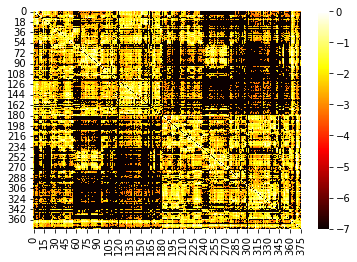

In [27]:
#### dmri glasser structural (density) networks - max node degree vs age replication
# if os.path.isfile(data_dir+'/'+groups[0]+'_dmri_glasser_preclean_adjacency.npy'):
#     dmri_glasser_networks_adjacency = np.load(data_dir+'/'+groups[0]+'_dmri_glasser_preclean_adjacency.npy',allow_pickle=True).item()
# else:
#     dmri_glasser_networks_adjacency = collectData('generic/network',['!measurements','networkmatrices','preprocessed'],['bl_paper','ga','structural','density'],'network.json.gz',data_dir+'/'+groups[0]+'_dmri_glasser_preclean_adjacency',True)

# # find binarized matrices
# bin_matrix = binarizeMatrices(dmri_glasser_networks_adjacency)

# # clean matrices
# dmri_glasser_networks_adjacency_cleaned = thresholdMatrices(dmri_glasser_networks_adjacency,bin_matrix,0.5)

# # compute node degree for each subject
# dmri_glasser_networks_adjacency_cleaned_nodes = pd.DataFrame()
# subs = []
# degree = []
# nodes = []
# for i in dmri_glasser_networks_adjacency_cleaned.keys():
#     subs = np.append(subs,[ str(i.split('_')[0]) for f in range(len(dmri_glasser_networks_adjacency_cleaned[i])) ])
#     nodes = np.append(nodes,[ str(f) for f in range(len(dmri_glasser_networks_adjacency_cleaned[i])) ])
#     degree = np.append(degree,bct.degrees_und(dmri_glasser_networks_adjacency_cleaned[i]))

# # set up 
# dmri_glasser_networks_adjacency_cleaned_nodes['subjectID'] = subs
# dmri_glasser_networks_adjacency_cleaned_nodes['node_degree'] = degree
# dmri_glasser_networks_adjacency_cleaned_nodes['node'] = nodes
# dmri_glasser_networks_adjacency_cleaned_nodes = pd.merge(dmri_glasser_networks_adjacency_cleaned_nodes,subjects_data.loc[subjects_data['subjectID'].isin(dmri_glasser_networks_adjacency_cleaned_nodes['subjectID'].unique())][['subjectID','age']],on='subjectID')

# bin ages as done in McPherson et al 2021
# bins = [18, 28, 38]
# dmri_glasser_networks_adjacency_cleaned_nodes['bin'] = pd.cut(dmri_glasser_networks_adjacency_cleaned_nodes['age'],bins)
# dmri_glasser_networks_adjacency_cleaned_nodes = dmri_glasser_networks_adjacency_cleaned_nodes.loc[~dmri_glasser_networks_adjacency_cleaned_nodes['node'].isin(['0','181'])]

# compute the max node degree per subject and save the max-node-degree dataframe
dmri_glasser_networks_adjacency_cleaned_nodes_max = dmri_glasser_networks_adjacency_cleaned_nodes.groupby('subjectID').apply(lambda x: np.max(x['node_degree'])).reset_index()
dmri_glasser_networks_adjacency_cleaned_nodes_max.rename(columns={0: "degree"},inplace=True)
# dmri_glasser_networks_adjacency_cleaned_nodes_max = pd.merge(dmri_glasser_networks_adjacency_cleaned_nodes_max,dmri_glasser_networks_adjacency_cleaned_nodes[['subjectID','age','bin']],on='subjectID')
dmri_glasser_networks_adjacency_cleaned_nodes_max = pd.merge(dmri_glasser_networks_adjacency_cleaned_nodes_max,dmri_glasser_networks_adjacency_cleaned_nodes[['subjectID']],on='subjectID')
dmri_glasser_networks_adjacency_cleaned_nodes_max['classID'] = [ groups[0] for f in range(len(dmri_glasser_networks_adjacency_cleaned_nodes_max)) ]
dmri_glasser_networks_adjacency_cleaned_nodes_max = dmri_glasser_networks_adjacency_cleaned_nodes_max.drop_duplicates()
# dmri_glasser_networks_adjacency_cleaned_nodes_max.to_csv(groups[0]+'-max-node-degree.csv',index=False)

sns.heatmap(np.nan_to_num(np.log10(dmri_glasser_networks_adjacency_cleaned['103818_sess1']),neginf=-7),cmap='hot',vmin=-7,vmax=0)
# plt.savefig('103818_density_net.eps',transparent=True)

In [18]:
dmri_glasser_networks_adjacency_cleaned_nodes_max 

,subjectID,degree,classID
0,100206,368.0,hcp
376,100307,367.0,hcp
752,100408,365.0,hcp
1128,100610,369.0,hcp
1504,101006,372.0,hcp
...,...,...,...
398184,992774,370.0,hcp
398560,993675,370.0,hcp
398936,994273,370.0,hcp
399312,995174,361.0,hcp


# Collecting functional network adjacency matrices
The next step of the analysis pipeline for me is to collect and analyze the functional connectivity matrices generated from functional MRI. To do this, I created matrices of the functional connectivity between parcels in the Yeo17 atlas for each participant. I then computed the 'within-network' average functional connectivity for each resting-state network in the Yeo atlas within each participant. This followed procedures outlined in This data was then used in Betzel et al (2014)[https://pubmed.ncbi.nlm.nih.gov/25109530/]. This data was used in Figure XX to identify the relationship between average within-network functional connectivity and participant age.

In [25]:
#### fmri yeo networks - max node degree vs age replication
if os.path.isfile(data_dir+'/'+groups[0]+'_fmri_yeo_preclean_adjacency.npy'):
    fmri_yeo_networks_adjacency = np.load(data_dir+'/'+groups[0]+'_fmri_yeo_preclean_adjacency.npy',allow_pickle=True).item()
else:
    fmri_yeo_networks_adjacency = collectData('generic/network',["time series"],['yeo-mni','final'],'network.json.gz',data_dir+'/'+groups[0]+'_fmri_yeo_preclean_adjacency',True)

# grab label indices
networks = ['VisCent','VisPeri','SomMotA','SomMotB','DorsAttnA','DorsAttnB','SalVentAttnA','SalVentAttnB','Limbic','ContA','ContB','ContC','DefaultA','DefaultB','DefaultC']
with open(data_dir+'/label.json','r') as label_f:
    labels = json.load(label_f)

indices = {}
for n in range(len(networks)):
    indices[networks[n]] = []
    for i in range(len(labels)):
        netname = labels[i]['name']
        if networks[n] in netname:
                indices[networks[n]] = np.append(indices[networks[n]],int(i))

# create average matrix
if os.path.isfile(data_dir+'/'+groups[0]+'_fmri_yeo_preclean_adjacency_mean.npy'):
    fmri_yeo_networks_adjacency_mean = np.load(data_dir+'/'+groups[0]+'_fmri_yeo_preclean_adjacency_mean.npy')
else:
    fmri_yeo_networks_adjacency_mean = fmri_yeo_networks_adjacency[list(fmri_yeo_networks_adjacency.keys())[0]]

    for i in fmri_yeo_networks_adjacency.keys():
        fmri_yeo_networks_adjacency_mean = fmri_yeo_networks_adjacency_mean + fmri_yeo_networks_adjacency[i]
    fmri_yeo_networks_adjacency_mean = fmri_yeo_networks_adjacency_mean / len(fmri_yeo_networks_adjacency.keys())
    np.save(data_dir+'/'+groups[0]+'_fmri_yeo_preclean_adjacency_mean.npy',fmri_yeo_networks_adjacency_mean)
    
# compute average functional connectivity (within network) for each network in yeo17
fmri_yeo_networks_adjacency_mean_fc = computeMeanNetworkConnectivity(fmri_yeo_networks_adjacency,networks,indices,"")

fmri_yeo_networks_adjacency_mean_fc

,subjectID,FC,classID,colors,structureID
0,100307,0.256095,hcp,blue,VisCent
1,100307,0.692158,hcp,blue,VisPeri
2,100307,0.940064,hcp,blue,SomMotA
3,100307,0.535629,hcp,blue,SomMotB
4,100307,0.581255,hcp,blue,DorsAttnA
...,...,...,...,...,...
9085,329844,0.480598,hcp,blue,ContB
9086,329844,0.517073,hcp,blue,ContC
9087,329844,0.512753,hcp,blue,DefaultA
9088,329844,0.361030,hcp,blue,DefaultB


# Removing outliers and creating reference datasets
Once all of the appropriate data was collected, collated, and cleaned, I was now able to generate useful 'reference datasets' that can be used to identify potentially problematic participant data. I adopted a similar methodology as in the Pestilli et al (2014) LiFE paper which created "reference datasets", i.e. dataset of values of high-quality and high-diverse data, of properties derived from the LiFE model. The authors of this publication have released this data in the backend of the LiFE app here on brainlife.io, allowing users to directly compare their newly generated results with previously currated results.

For this project, I took a similar approach across three large and diverse datasets: PING, HCP, and CAMCAN. For each data modality and structure, I computed the average value across many different models and measures including structural statistics derived from Freesurfer, diffusion microsturctural statistics derived from the DTI and NODDI models, and network measures such as max node degree from structural connectivity measures and average functional connectivity derived from fMRI. I then identified those data points that were outside the top and bottom 5% of the distribution, removed them, and recomputed the distribution. This newly cleaned distribution is the 'reference dataset' for that datatype, measure, and dataset.

Following iterating through many datatypes, measures, structures, and projects, I released the final reference datasets on github and we have incorporated the data into the validators for the apps that generate those particular datatypes! This way users can directly compare their newly generated data with those I processed, analyzed, and curated!!

In [43]:
### creating reference datasets
print("creating references for subcortical cortical and tractmeasures data")

if not os.path.isdir(data_dir+'/references'):
    os.mkdir(data_dir+'/references')

# compute reference dataset for subcortical structures
# subcortical_structural_measures = ['number_of_voxels','volume']
# subcortical_structural_distances, subcortical_structural_outliers, subcortical_structural_reference_dataframe, subcortical_structural_reference_json = outlierDetection(subcortical,subcortical.structureID.unique(),'structureID',subcortical_structural_measures,95,'emd',True,False,'',groups[0],data_dir+'/references','subcortical_structural_reference_'+groups[0])
# subcortical_diffusion_measures = ['ad','fa','md','rd','ndi','odi','isovf']
# subcortical_diffusion_distances, subcortical_diffusion_outliers, subcortical_diffusion_reference_dataframe, subcortical_diffusion_reference_json = outlierDetection(subcortical,subcortical.structureID.unique(),'structureID',subcortical_diffusion_measures,95,'emd',True,False,'',groups[0],data_dir+'/references','subcortical_diffusion_reference_'+groups[0])

# compute reference dataset for cortical structures
# cortical_diffusion_measures = ['ad','fa','md','rd','ndi','isovf','odi']    
# cortical_diffusion_distances, cortical_diffusion_outliers, cortical_diffusion_reference_dataframe, cortical_diffusion_reference_json = outlierDetection(cortical,cortical.structureID.unique(),'structureID',cortical_diffusion_measures,95,'emd',True,False,"",groups[0],data_dir+'/references','cortical_diffusion_reference_'+groups[0])
# cortical_structural_measures = ['number_of_vertices','surface_area_mm^2','gray_matter_volume_mm^3','average_thickness_mm','thickness_stddev_mm','integrated_rectified_mean_curvature_mm^-1','integrated_rectified_gaussian_curvature_mm^-2','folding_index','intrinsic_curvature_index']
# cortical_structural_distances, cortical_structural_outliers, cortical_structural_reference_dataframe, cortical_structural_reference_json = outlierDetection(cortical,cortical.structureID.unique(),'structureID',cortical_structural_measures,95,'emd',True,False,"",groups[0],data_dir+'/references','cortical_structural_reference_'+groups[0])

# compute reference dataset for tractmeasures  
# track_structural_measures = [ f for f in track_data.keys() if f not in diff_micro_measures + subjects_data.keys().tolist() + ['structureID','sessionID','nodeID','ExponentialFitA','ExponentialFitB'] + track_data.columns[track_data.isna().any()].tolist() ]
# track_structural_distances, track_structural_outliers, track_structural_reference_dataframe, track_structural_reference_json = outlierDetection(track_data_mean,track_data_mean.structureID.unique(),'structureID',track_structural_measures,95,'emd',True,False,"",groups[0],data_dir+'/references','tractmeasures_structural_reference_'+groups[0])
# track_diffusion_measures = ['ad','fa','md','rd']
# track_diffusion_distances, track_diffusion_outliers, track_diffusion_reference_dataframe, track_diffusion_reference_json = outlierDetection(track_data,[track_data.structureID.unique()[0]],'nodeID',track_diffusion_measures,99.5,'euclidean',True,True,50,groups[0],data_dir+'/references','tractmeasures_diffusion_reference_'+groups[0]+'_tensor_995')
# track_diffusion_measures = ['ndi','odi','isovf']
# track_diffusion_distances, track_diffusion_outliers, track_diffusion_reference_dataframe, track_diffusion_reference_json = outlierDetection(track_data,track_data.structureID.unique(),'nodeID',track_diffusion_measures,99,'euclidean',True,True,50,groups[0],data_dir+'/references','tractmeasures_diffusion_reference_'+groups[0]+'_noddi_99')

# compute reference dataset of fmri within network FC
# fmri_within_network_fc_measures = ['FC']
# fmri_within_network_fc_distances, fmri_within_network_fc_outliers, fmri_within_network_fc_reference_dataframe, fmri_within_network_fc_reference_json = outlierDetection(fmri_yeo_networks_adjacency_mean_fc,fmri_yeo_networks_adjacency_mean_fc.structureID.unique(),'structureID',['FC'],95,'emd',True,False,'',groups[0],data_dir+'/references','fmri_within_network_fc_'+groups[0])
fmri_within_network_fc_reference_dataframe.loc[fmri_within_network_fc_reference_dataframe['structureID'] == 'DefaultA']

# compute reference dataset for diffusion b0 SNR - CC
# diffusion_snr_measures = ['snr']
# diffusion_snr_distances, diffusion_snr_outliers, diffusion_snr_reference_dataframe, diffusion_snr_reference_json = outlierDetection(diffusion_snr_data,['b0'],'structureID',diffusion_snr_measures,95,'emd',True,False,'',groups[0],data_dir+'/references','diffusion_snr_callosal_reference_'+groups[0])

# merge reference datasets together for easier download and upload
# mergeStructuralDiffusionJson(cortical,data_dir+'/references/cortical_structural_reference_'+groups[0],data_dir+'/references/cortical_diffusion_reference_'+groups[0],data_dir+'/references/cortical_reference_'+groups[0])
# mergeStructuralDiffusionJson(subcortical,data_dir+'/references/subcortical_structural_reference_'+groups[0],data_dir+'/references/subcortical_diffusion_reference_'+groups[0],data_dir+'/references/subcortical_reference_'+groups[0])
# mergeStructuralDiffusionJson(track_data,data_dir+'/references/tractmeasures_diffusion_reference_'+groups[0]+'_tensor',data_dir+'/references/tractmeasures_diffusion_reference_'+groups[0]+'_noddi',data_dir+'/references/tractmeasures_diffusion_reference_'+groups[0])
# mergeStructuralDiffusionJson(track_data,data_dir+'/references/tractmeasures_structural_reference_'+groups[0],data_dir+'/references/tractmeasures_diffusion_reference_'+groups[0],data_dir+'/references/tractmeasures_reference_'+groups[0])

print("creating references complete")

creating references for subcortical cortical and tractmeasures data
L_V1_ROI
L_MST_ROI
L_V6_ROI
L_V2_ROI
L_V3_ROI
L_V4_ROI
L_V8_ROI
L_4_ROI
L_3b_ROI
L_FEF_ROI
L_PEF_ROI
L_55b_ROI
L_V3A_ROI
L_RSC_ROI
L_POS2_ROI
L_V7_ROI
L_IPS1_ROI
L_FFC_ROI
L_V3B_ROI
L_LO1_ROI
L_LO2_ROI
L_PIT_ROI
L_MT_ROI
L_A1_ROI
L_PSL_ROI
L_SFL_ROI
L_PCV_ROI
L_STV_ROI
L_7Pm_ROI
L_7m_ROI
L_POS1_ROI
L_23d_ROI
L_v23ab_ROI
L_d23ab_ROI
L_31pv_ROI
L_5m_ROI
L_5mv_ROI
L_23c_ROI
L_5L_ROI
L_24dd_ROI
L_24dv_ROI
L_7AL_ROI
L_SCEF_ROI
L_6ma_ROI
L_7Am_ROI
L_7PL_ROI
L_7PC_ROI
L_LIPv_ROI
L_VIP_ROI
L_MIP_ROI
L_1_ROI
L_2_ROI
L_3a_ROI
L_6d_ROI
L_6mp_ROI
L_6v_ROI
L_p24pr_ROI
L_33pr_ROI
L_a24pr_ROI
L_p32pr_ROI
L_a24_ROI
L_d32_ROI
L_8BM_ROI
L_p32_ROI
L_10r_ROI
L_47m_ROI
L_8Av_ROI
L_8Ad_ROI
L_9m_ROI
L_8BL_ROI
L_9p_ROI
L_10d_ROI
L_8C_ROI
L_44_ROI
L_45_ROI
L_47l_ROI
L_a47r_ROI
L_6r_ROI
L_IFJa_ROI
L_IFJp_ROI
L_IFSp_ROI
L_IFSa_ROI
L_p9-46v_ROI
L_46_ROI
L_a9-46v_ROI
L_9-46d_ROI
L_9a_ROI
L_10v_ROI
L_a10p_ROI
L_10pp_ROI
L_11l_ROI
L_13l_ROI
L_OFC_RO

KeyboardInterrupt: 

# Generating visualizations and plots
These are visualizations describing the reference dataframe generation. For the sake of this notebook, I will just show the figures for the 'within-network' functional connectivity reference dataframe results!

default-a


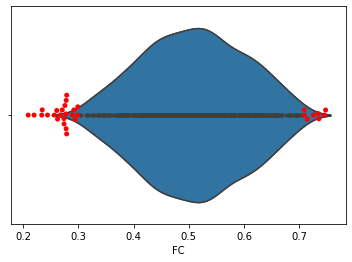

In [75]:
#### generate figures documenting outlier detection capabilities
## track data: example anterior frontal CC
# track_diffusion_reference_dataframe = pd.read_csv(data_dir+'/references/tractmeasures_diffusion_reference_'+groups[0]+'_tensor_99.csv')
# track_diffusion_reference_dataframe['classID'] = [ 'hcp' for f in track_diffusion_reference_dataframe['subjectID'] ]
# track_diffusion_reference_dataframe['colors'] = [ 'blue' for f in track_diffusion_reference_dataframe['subjectID'] ]

# # generate plot pre-outlier computation
# fig = plotProfiles(['anterioFrontalCC'],track_data,['fa'],'mean','std',"","")
# plt.savefig('./img/anterior_frontal_cc_fa_pre_outliers_example.eps')
# plt.savefig('./img/anterior_frontal_cc_fa_pre_outliers_example.png')
# plt.close()

# # generate outliers and reference plot
# fig = plotProfiles(['anterioFrontalCC'],track_diffusion_reference_dataframe.loc[track_diffusion_reference_dataframe['structureID'] == 'anterioFrontalCC'],['fa'],'mean','std',"","")
# sns.lineplot(x='nodeID',y='fa',data=track_data.loc[track_data['structureID'] == 'anterioFrontalCC'].loc[~track_data['subjectID'].isin(track_diffusion_reference_dataframe.loc[track_diffusion_reference_dataframe['structureID'] == 'anterioFrontalCC'].loc[~track_diffusion_reference_dataframe['fa'].isna()]['subjectID'].tolist())],hue='subjectID',legend=False,linewidth=5)
# plt.savefig('./img/anterior_frontal_cc_fa_outliers_example.eps')
# plt.savefig('./img/anterior_frontal_cc_fa_outliers_example.png')
# plt.close()

# # generate reference plot
# fig = plotProfiles(['anterioFrontalCC'],track_diffusion_reference_dataframe.loc[track_diffusion_reference_dataframe['structureID'] == 'anterioFrontalCC'].loc[~track_diffusion_reference_dataframe['fa'].isna()],['fa'],'mean','std',img_dir,'anterior')
# plt.savefig('./img/anterior_frontal_cc_fa_reference_example.eps')
# plt.savefig('./img/anterior_frontal_cc_fa_reference_example.png')
# plt.close()

# ## subcortical data: left hippocampus
# subcortical_structural_reference_dataframe = pd.read_csv(data_dir+'/references/subcortical_reference_'+groups[0]+'.csv')

# # generate distribution of volume pre outliers
# sns.violinplot(x='volume',data=subcortical.loc[subcortical['structureID'] == 'Left-Hippocampus'],scale='count',inner='points')
# plt.savefig('./img/left_hippocampus_volume_pre_outliers_example.png')
# plt.savefig('./img/left_hippocampus_volume_pre_outliers_example.eps')
# plt.close()

# # generate distribution of volume with outliers
# sns.violinplot(x='volume',data=subcortical_structural_reference_dataframe.loc[subcortical_structural_reference_dataframe['structureID'] == 'Left-Hippocampus'].loc[~subcortical_structural_reference_dataframe['volume'].isna()],scale='count',inner='points')
# sns.swarmplot(x='volume',data=subcortical.loc[subcortical['structureID'] == 'Left-Hippocampus'].loc[~subcortical['subjectID'].isin(subcortical_structural_reference_dataframe.loc[subcortical_structural_reference_dataframe['structureID'] == 'Left-Hippocampus'].loc[~subcortical_structural_reference_dataframe['volume'].isna()]['subjectID'].tolist())],color='red')
# plt.savefig('./img/left_hippocampus_volume_outliers_example.png')
# plt.savefig('./img/left_hippocampus_volume_outliers_example.eps')
# plt.close()

# # generate reference
# sns.violinplot(x='volume',data=subcortical_structural_reference_dataframe.loc[subcortical_structural_reference_dataframe['structureID'] == 'Left-Hippocampus'].loc[~subcortical_structural_reference_dataframe['volume'].isna()],scale='count',inner='points')
# plt.savefig('./img/left_hippocampus_volume_reference_example.png')
# plt.savefig('./img/left_hippocampus_volume_reference_example.eps')
# plt.close()

# fmri networks - average degree: DMN
# grab default mode a network nodes and average
if os.path.isfile(data_dir+'/'+groups[0]+'-within-network-default-a-preclean-fc.csv'):
    default_a_preclean_df = pd.read_csv(data_dir+'/'+groups[0]+'-within-network-default-a-preclean-fc.csv')
else:
    default_a_preclean_df = fmri_yeo_networks_adjacency_mean_fc.loc[fmri_yeo_networks_adjacency_mean_fc['structureID'] == 'DefaultA']
    default_a_preclean_df.to_csv(data_dir+'/'+groups[0]+'-within-network-default-a-preclean-fc.csv',index=False)

# generate distribution of volume pre outliers
sns.violinplot(x='FC',data=default_a_preclean_df,scale='count',inner='points')
plt.savefig('./img/default_a_fc_pre_outliers_example.png')
plt.savefig('./img/default_a_fc_pre_outliers_example.eps')
plt.close()

# generate outliers and reference plot
default_a_distances, default_a_outliers, default_a_reference_dataframe, default_a_reference_json = outlierDetection(default_a_preclean_df,default_a_preclean_df.structureID.unique(),'structureID',['FC'],95,'emd',True,False,"",groups[0],data_dir+'/references','default_a_fc_references_'+groups[0])

# generate distribution of node degree with outliers
outliers_subs = default_a_outliers['subjectID'].unique()
default_a_reference = default_a_preclean_df.loc[~default_a_preclean_df['subjectID'].isin(outliers_subs)]
default_a_outliers = default_a_preclean_df.loc[default_a_preclean_df['subjectID'].isin(outliers_subs)]
sns.violinplot(x='FC',data=default_a_reference,scale='count',inner='points')
sns.swarmplot(x='FC',data=default_a_outliers,color='red')
plt.savefig('./img/default_a_fc_outliers_example.png')
plt.savefig('./img/default_a_fc_outliers_example.eps')
# plt.close()

# generate reference
sns.violinplot(x='FC',data=default_a_reference,scale='count',inner='points')
plt.savefig('./img/default_a_fc_reference_example.png')
plt.savefig('./img/default_a_fc_reference_example.eps')
# plt.close()

# Replicating previous literature: Fukutomi et al 2018
Now that I've analyzed many of the common datatypes available on brainlife.io, including anatomical (T1w, T2w), diffusion, and functional MRI, it's time to attempt to replicate some previously published literature!

For this, I chose to replicate the relationship between orientation dispersion index (ODI), or the amount of spreading exists between axons and dendrites (derived from the NODDI model), of a cortical parcel with it's thickness. This relationship was first identified by Fukutomi et al (2018)[https://pubmed.ncbi.nlm.nih.gov/29448073/#].

To do this, I took the cleaned cortical data generated in previous sections and identified the values that corresponded to the HCP-MMP parcellation (i.e. 'glasser'). I then generated a reference dataset removing the top and bottom 5% of data before computing the average ODI per parcel across all subjects and compared that with that's parcel average cortical thickness.

The original paper found a correlation of -0.46 with roughly 505 participants. In this analysis, I've doubled the number of subjects used (1000) and identified a similar correlation (-0.42), replicating this particular finding!

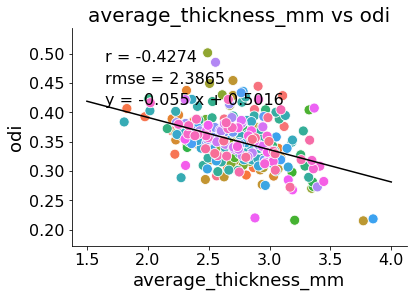

In [64]:
## replicate Fukutomi et al 2018 results
# identify glasser structures with average snr > 17
good_glasser_structures = [ f for f in cortical.loc[cortical['parcellation'] == 'glasser']['structureID'].unique()[cortical.loc[cortical['parcellation'] == 'glasser'].groupby('structureID',as_index=False).mean()['snr'] > 17] if not 'lh' in f if not 'rh' in f]

# grab reference datasets
if os.path.isfile(data_dir+'/references/cortical_reference_'+groups[0]+'_fukutomi.csv'):
    cortical_diffusion_reference_dataframe = pd.read_csv(data_dir+'/references/cortical_reference_'+groups[0]+'_fukutomi.csv')
else:
    cortical_measures = ['odi','average_thickness_mm']    
    cortical_diffusion_reference_distances, cortical_diffusion_reference_outliers, cortical_diffusion_reference_dataframe, cortical_diffusion_reference_json = outlierDetection(cortical,good_glasser_structures,'structureID',cortical_measures,95,'emd',True,False,"",groups[0],data_dir+'/references','cortical_reference_'+groups[0]+'_fukutomi')

# plot data
singleplotScatter("",cortical_diffusion_reference_dataframe.groupby(['structureID'],as_index=False).mean(),cortical_diffusion_reference_dataframe.groupby(['structureID'],as_index=False).mean(),'average_thickness_mm','odi',False,'structureID','structureID','ravel','linreg',False,False,'','','')

# Generating glass brain plots of structural connectivity properties

In [71]:
#### generate network glass brain images
# load coords
glasser_coords = np.load(data_dir+'/glasser_coords.npy')
# yeo_coords = np.load('yeo_coords.npy')

# compute clustering coefficient for visualization: structural glasser
dmri_glasser_networks_adjacency_cleaned_mean = dmri_glasser_networks_adjacency_cleaned[list(dmri_glasser_networks_adjacency_cleaned.keys())[0]]

for i in dmri_glasser_networks_adjacency_cleaned.keys():
    dmri_glasser_networks_adjacency_cleaned_mean = (dmri_glasser_networks_adjacency_cleaned_mean + dmri_glasser_networks_adjacency_cleaned[i])
dmri_glasser_networks_adjacency_cleaned_mean = dmri_glasser_networks_adjacency_cleaned_mean / len(dmri_glasser_networks_adjacency_cleaned.keys())

    # np.save(data_dir+'/'+groups[0]+'_fmri_yeo_preclean_adjacency_mean.npy',fmri_yeo_networks_adjacency_mean)
glasser_cluster = bct.clustering_coef_wu(dmri_glasser_networks_adjacency_cleaned_mean)

# compute clustering coefficient for visualization: functional yeo
# yeo_cluster = bct.clustering_coef_wd(fmri_yeo_networks_adjacency_mean)

# generate html: structural glasser
glasser_view = plotting.view_connectome(dmri_glasser_networks_adjacency_cleaned_mean,glasser_coords,node_size=glasser_cluster*600,edge_cmap='hot',symmetric_cmap=False,edge_threshold='99%')
# glasser_view.save_as_html(img_dir+'/glasser_structural_density_glass_brain.html')
glasser_view.open_in_browser()


# generate html: functional yeo
# glasser_view = plotting.view_connectome(fmri_yeo_networks_adjacency_mean,yeo_coords,node_size=yeo_cluster*200,edge_cmap='hot',edge_threshold='97.5%')
# glasser_view.save_as_html(img_dir+'/yeo_functional_connectivity_glass_brain.html')

AttributeError: 'ConnectomeView' object has no attribute 'show'

In [74]:
glasser_view.open_in_browser()